# PREDICTIVE ML MODEL TRAINING THROUGH CMAPSS DATA SET 

### Set-up & Imports

In [1]:
# 0/ Setup & minimal imports (clean)
import warnings
warnings.filterwarnings('ignore')

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler

# Reproducibility
random.seed(42)
np.random.seed(42)

# Display options for readable, aligned outputs
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

# Small helpers for tidy logs
def print_header(title: str):
    line = '=' * 70
    print(f"\n{line}\n{title}\n{line}")

def print_kv(pairs):
    # pairs: list of (key, value)
    width = max(len(str(k)) for k, _ in pairs) if pairs else 0
    for k, v in pairs:
        print(f"{str(k).ljust(width)} : {v}")

print("Setup complete")

Setup complete


## 1) Data Loading

In [2]:
# 1/ Load FD001 (train/test/rul)
print_header("Loading CMAPSS FD001")
train1 = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
test1  = pd.read_csv('test_FD001.txt',  sep='\s+', header=None)
rul1   = pd.read_csv('RUL_FD001.txt',   header=None, names=['RUL'])

# Basic validation
assert train1.shape[1] == 26, f"Unexpected train columns: {train1.shape[1]}"
assert test1.shape[1]  == 26, f"Unexpected test columns: {test1.shape[1]}"
assert 'RUL' in rul1.columns and rul1.shape[1] == 1, "RUL file format unexpected"

print_kv([
    ("train shape (rows, cols)", train1.shape),
    ("test shape (rows, cols)",  test1.shape),
    ("rul shape (rows, cols)",   rul1.shape),
])


Loading CMAPSS FD001
train shape (rows, cols) : (20631, 26)
test shape (rows, cols)  : (13096, 26)
rul shape (rows, cols)   : (100, 1)


## 2) Explanatory Data Analysis

In [3]:
# 2/ Dataset quick summary (types, basic stats)
print_header("Dataset Summary")

def summarize_df(name, df):
    rows, cols = df.shape
    dtypes = df.dtypes.value_counts()
    dtype_str = ", ".join([f"{dt}: {cnt}" for dt, cnt in dtypes.items()])
    pairs = [
        (f"{name} rows", rows),
        (f"{name} cols", cols),
        (f"{name} dtypes", dtype_str),
    ]
    print_kv(pairs)

summarize_df("train", train1)
summarize_df("test",  test1)
print_kv([("rul rows", rul1.shape[0])])


Dataset Summary
train rows   : 20631
train cols   : 26
train dtypes : float64: 22, int64: 4
test rows   : 13096
test cols   : 26
test dtypes : float64: 22, int64: 4
rul rows : 100


In [4]:
# 3/ Column indices before naming
print_header("Column indices before naming (first 10 shown)")
print(list(train1.columns[:10]))


Column indices before naming (first 10 shown)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [5]:
# 4/ Apply CMAPSS column names (FD001)
print_header("Applying column names")
sensor_names = [
                    # Index
                    'unit', 'cycle',
                    # Settings
                    'opset1', 'opset2', 'opset3',
                    # Sensors
                    'Fan_Inlet_Temp',               # "sensor1" : Fan Inlet Temperature (◦R)
                    'LPC_Outlet_Temp',              # "sensor2" : LPC Outlet Temperature (◦R)
                    'HPC_Outlet_Temp',              # "sensor3" : HPC Outlet Temperature (◦R)
                    'LPT_Outlet_Temp',              # "sensor4" : LPT Outlet Temperature (◦R)
                    'Fan_Inlet_Press',              # "sensor5" : Fan Inlet Pressure (psia)
                    'Bypass_Duct',                  # "sensor6" : Bypass-Duct Pressure (psia)
                    'HPC_Outlet_Press',             # "sensor7" : HPC Outlet Pressure (psia)
                    'Physical_Fan_Speed',           # "sensor8" : Physical Fan Speed (rpm)
                    'Physical_Core_Speed',          # "sensor9" : Physical Core Speed (rpm)
                    'Engine_Press_Ratio',           # "sensor10" : Engine Pressure Ratio(P50/P2)
                    'HPC_Outlet_Static_Press',      # "sensor11" : HPC Outlet Static Pressure (psia)
                    'Fuel_Flow_Ratio',              # "sensor12" : Ratio of Fuel Flow to Ps30 (pps/psia)
                    'Corrected_Fan_Speed',          # "sensor13" : Corrected Fan Speed (rpm)
                    'Corrected_Core_Speed',         # "sensor14" : Corrected Core Speed (rpm)
                    'Bypass_Ratio',                 # "sensor15" : Bypass Ratio
                    'Fuel_Air_Ratio',               # "sensor16" : Burner Fuel-Air Ratio
                    'Bleed_Enthalpy',               # "sensor17" : Bleed Enthalpy
                    'Req_Fan_Speed',                # "sensor18" : Required Fan Speed
                    'Req_Core_Speed',               # "sensor19" : Required Fan Conversion Speed
                    'HPT_Cool_Air_F',               # "sensor20" : High-Pressure Turbines Cool Air Flow
                    'LPT_Cool_Air_F'                # "sensor21" : Low-Pressure Turbines Cool Air Flow
                ]

train1.columns = sensor_names
test1.columns  = sensor_names

# Validate
assert len(train1.columns) == 26 and len(test1.columns) == 26, "Column naming failed"
assert train1.columns.equals(test1.columns), "Train/Test column mismatch after naming"

print_kv([
    ("columns applied", True),
    ("first 8 columns", train1.columns[:8].tolist()),
])

# quick peek
print_header("Head (train/test) after naming")
print("train head:\n", train1.head(5))
print("\n---\n")
print("test head:\n",  test1.head(5))


Applying column names
columns applied : True
first 8 columns : ['unit', 'cycle', 'opset1', 'opset2', 'opset3', 'Fan_Inlet_Temp', 'LPC_Outlet_Temp', 'HPC_Outlet_Temp']

Head (train/test) after naming
train head:
    unit  cycle     opset1     opset2  opset3  Fan_Inlet_Temp  LPC_Outlet_Temp  HPC_Outlet_Temp  LPT_Outlet_Temp  \
0     1      1 -7.000e-04 -4.000e-04   100.0          518.67           641.82          1589.70          1400.60   
1     1      2  1.900e-03 -3.000e-04   100.0          518.67           642.15          1591.82          1403.14   
2     1      3 -4.300e-03  3.000e-04   100.0          518.67           642.35          1587.99          1404.20   
3     1      4  7.000e-04  0.000e+00   100.0          518.67           642.35          1582.79          1401.87   
4     1      5 -1.900e-03 -2.000e-04   100.0          518.67           642.37          1582.85          1406.22   

   Fan_Inlet_Press  Bypass_Duct  HPC_Outlet_Press  Physical_Fan_Speed  Physical_Core_Speed  Engi

In [6]:
# 5/ Tail check (sanity)
print_header("Tail (train/test)")
print("train tail:\n", train1.tail(5))
print("\n---\n")
print("test tail:\n",  test1.tail(5))


Tail (train/test)
train tail:
        unit  cycle     opset1     opset2  opset3  Fan_Inlet_Temp  LPC_Outlet_Temp  HPC_Outlet_Temp  LPT_Outlet_Temp  \
20626   100    196 -4.000e-04 -3.000e-04   100.0          518.67           643.49          1597.98          1428.63   
20627   100    197 -1.600e-03 -5.000e-04   100.0          518.67           643.54          1604.50          1433.58   
20628   100    198  4.000e-04  0.000e+00   100.0          518.67           643.42          1602.46          1428.18   
20629   100    199 -1.100e-03  3.000e-04   100.0          518.67           643.23          1605.26          1426.53   
20630   100    200 -3.200e-03 -5.000e-04   100.0          518.67           643.85          1600.38          1432.14   

       Fan_Inlet_Press  Bypass_Duct  HPC_Outlet_Press  Physical_Fan_Speed  Physical_Core_Speed  Engine_Press_Ratio  \
20626            14.62        21.61            551.43             2388.19              9065.52                 1.3   
20627            

In [7]:
# 6/ Null check (train/test)
print_header("Null values (train/test)")
null_train = train1.isnull().sum()
null_test  = test1.isnull().sum()

print("train nulls (non-zero shown):\n", null_train[null_train>0])
print("\n---\n")
print("test nulls (non-zero shown):\n",  null_test[null_test>0])

# Validation
assert int(null_train.sum()) == 0, "Train contains nulls"
assert int(null_test.sum())  == 0, "Test contains nulls"
print("All null checks passed.")


Null values (train/test)
train nulls (non-zero shown):
 Series([], dtype: int64)

---

test nulls (non-zero shown):
 Series([], dtype: int64)
All null checks passed.


In [8]:
# 7/ Duplicate row check (train/test)
print_header("Duplicate rows (train/test)")
dup_train = int(train1.duplicated().sum())
dup_test  = int(test1.duplicated().sum())
print_kv([
            ("train duplicates", dup_train),
            ("test duplicates",  dup_test),
        ])

# Validation (allow zero only)
assert dup_train == 0, "Train contains duplicate rows"
assert dup_test  == 0, "Test contains duplicate rows"
print("Duplicate checks passed.")


Duplicate rows (train/test)
train duplicates : 0
test duplicates  : 0
Duplicate checks passed.


In [9]:
# 8/ Unique units (train/test)
print_header("Unique units (train/test)")

u_train = train1['unit'].nunique()
u_test  = test1['unit'].nunique()

print_kv([
            ("train unique units", u_train),
            ("test unique units",  u_test),
        ])



Unique units (train/test)
train unique units : 100
test unique units  : 100



Unit Lifecycle Distribution


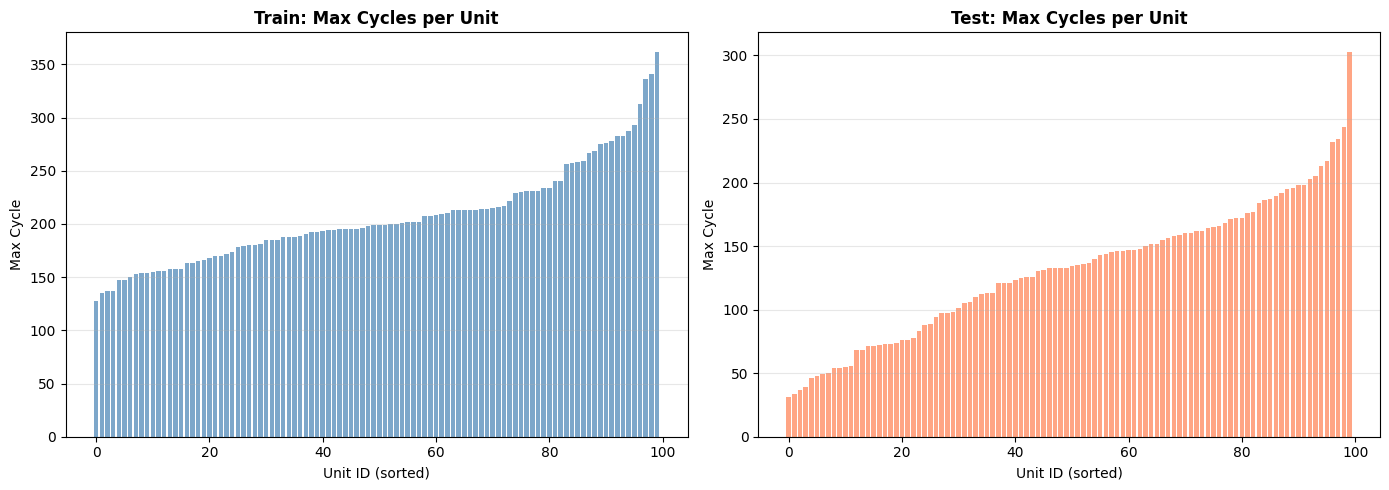

Train | avg cycles per unit : 206.3
Train | min/max cycles      : 128 / 362
Test  | avg cycles per unit : 131.0
Test  | min/max cycles      : 31 / 303


In [10]:
# 8b/ Unit lifecycle visualization
print_header("Unit Lifecycle Distribution")

# Calculate cycle counts per unit
train_cycles = train1.groupby('unit')['cycle'].max().sort_values()
test_cycles = test1.groupby('unit')['cycle'].max().sort_values()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train
axes[0].bar(range(len(train_cycles)), train_cycles.values, color='steelblue', alpha=0.7)
axes[0].set_title('Train: Max Cycles per Unit', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Unit ID (sorted)')
axes[0].set_ylabel('Max Cycle')
axes[0].grid(alpha=0.3, axis='y')

# Test
axes[1].bar(range(len(test_cycles)), test_cycles.values, color='coral', alpha=0.7)
axes[1].set_title('Test: Max Cycles per Unit', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Unit ID (sorted)')
axes[1].set_ylabel('Max Cycle')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary
print_kv([
    ("Train | avg cycles per unit", f"{train_cycles.mean():.1f}"),
    ("Train | min/max cycles", f"{train_cycles.min()} / {train_cycles.max()}"),
    ("Test  | avg cycles per unit", f"{test_cycles.mean():.1f}"),
    ("Test  | min/max cycles", f"{test_cycles.min()} / {test_cycles.max()}"),
])

In [11]:
# 9/ Describe (train/test) — numeric columns
print_header("Describe (numeric) — train")
print(train1.describe().T.round(3))

print_header("Describe (numeric) — test")
print(test1.describe().T.round(3))


Describe (numeric) — train
                           count      mean     std       min       25%       50%       75%       max
unit                     20631.0    51.507  29.228     1.000    26.000    52.000    77.000   100.000
cycle                    20631.0   108.808  68.881     1.000    52.000   104.000   156.000   362.000
opset1                   20631.0    -0.000   0.002    -0.009    -0.002     0.000     0.002     0.009
opset2                   20631.0     0.000   0.000    -0.001    -0.000     0.000     0.000     0.001
opset3                   20631.0   100.000   0.000   100.000   100.000   100.000   100.000   100.000
Fan_Inlet_Temp           20631.0   518.670   0.000   518.670   518.670   518.670   518.670   518.670
LPC_Outlet_Temp          20631.0   642.681   0.500   641.210   642.325   642.640   643.000   644.530
HPC_Outlet_Temp          20631.0  1590.523   6.131  1571.040  1586.260  1590.100  1594.380  1616.910
LPT_Outlet_Temp          20631.0  1408.934   9.001  1382.250  1


Correlation matrix (train)


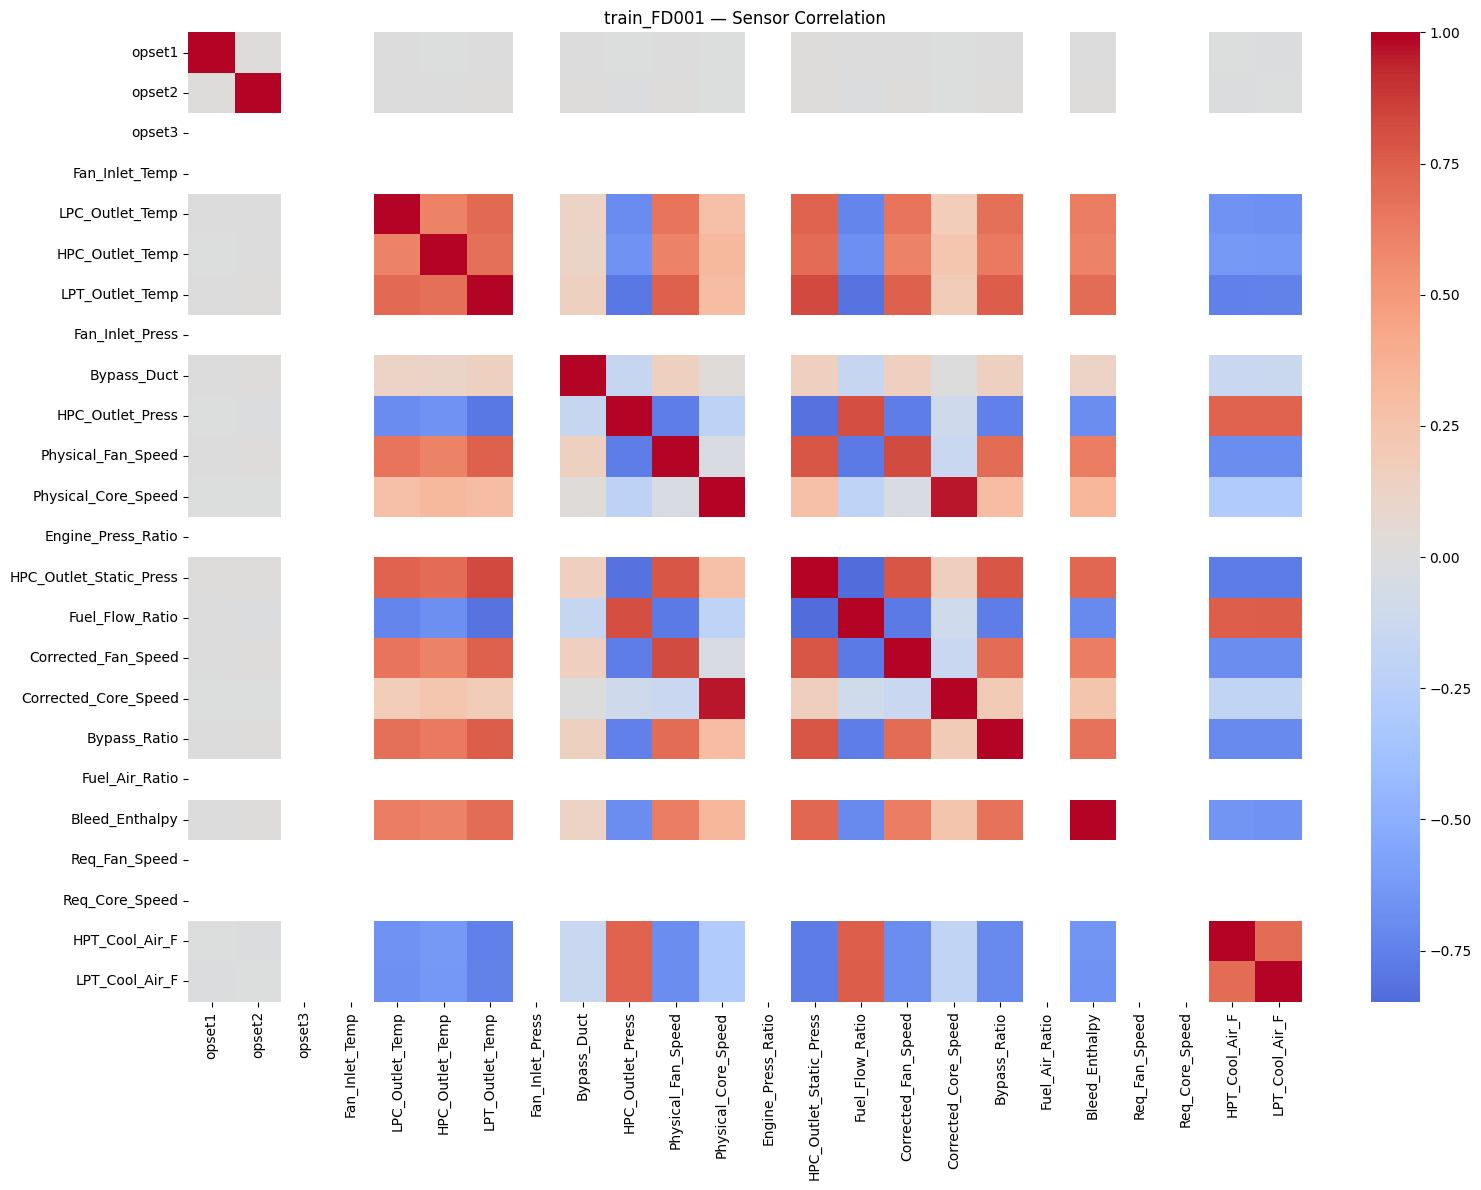

In [12]:
# 10/ Correlation (train) — heatmap
print_header("Correlation matrix (train)")

def plot_corr_heatmap(df, title):
    df_numeric = df.drop(["unit", "cycle"], axis=1, errors='ignore')
    corr = df_numeric.corr()
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_corr_heatmap(train1, "train_FD001 — Sensor Correlation")


RUL Labeling and Distribution


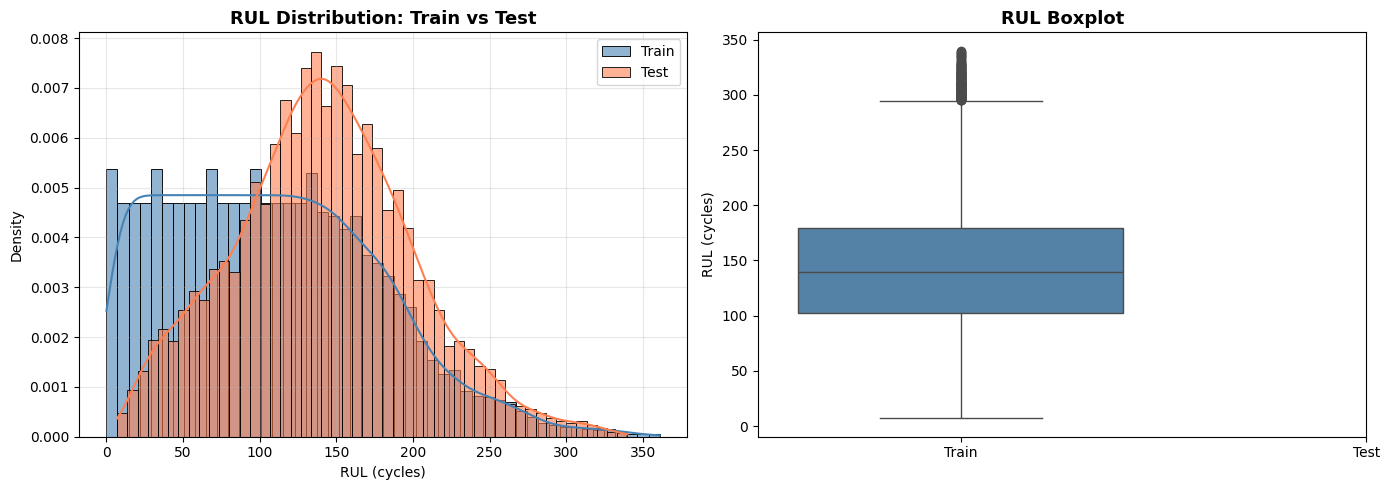


RUL Statistics
Train RUL | mean / std : 107.8 / 68.9
Train RUL | min / max  : 0 / 361
Test RUL  | mean / std : 141.2 / 59.0
Test RUL  | min / max  : 7 / 340
Low RUL (<30) % : Train: 14.5% | Test: 2.3%


In [13]:
# 11/ RUL labeling (Train: unit-based | Test: ground truth from rul.txt)
print_header("RUL Labeling and Distribution")

def add_rul_train(df):
    """Calculate RUL for train: max_cycle - current_cycle per unit"""
    df = df.copy()
    max_cycles = df.groupby('unit')['cycle'].transform('max')
    df['RUL'] = max_cycles - df['cycle']
    return df

def add_rul_test(df, rul_df):
    """Calculate RUL for test: use ground truth RUL file"""
    df = df.copy()
    # Get last cycle per unit
    last_cycles = df.groupby('unit')['cycle'].max().reset_index()
    last_cycles.columns = ['unit', 'last_cycle']
    
    # Merge ground truth RUL (rul_df is 1 value per unit, same order as unique units)
    last_cycles['RUL_at_last'] = rul_df['RUL'].values
    
    # Merge back and calculate RUL for each row
    df = df.merge(last_cycles[['unit', 'last_cycle', 'RUL_at_last']], on='unit', how='left')
    df['RUL'] = df['RUL_at_last'] + (df['last_cycle'] - df['cycle'])
    df = df.drop(['last_cycle', 'RUL_at_last'], axis=1)
    return df

# Apply RUL calculation
train_rul = add_rul_train(train1)
test_rul = add_rul_test(test1, rul1)

# Validation
assert 'RUL' in train_rul.columns and 'RUL' in test_rul.columns, "RUL column missing"
assert (train_rul['RUL'] >= 0).all(), "Train RUL contains negative values"
assert (test_rul['RUL'] >= 0).all(), "Test RUL contains negative values"

# Distribution comparison
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_rul['RUL'], kde=True, color='steelblue', label='Train', alpha=0.6, bins=50, stat='density')
sns.histplot(test_rul['RUL'], kde=True, color='coral', label='Test', alpha=0.6, bins=50, stat='density')
plt.title('RUL Distribution: Train vs Test', fontsize=13, fontweight='bold')
plt.xlabel('RUL (cycles)')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
sns.boxplot(data=[train_rul['RUL'], test_rul['RUL']], palette=['steelblue', 'coral'])
plt.xticks([0, 1], ['Train', 'Test'])
plt.title('RUL Boxplot', fontsize=13, fontweight='bold')
plt.ylabel('RUL (cycles)')
plt.tight_layout()
plt.show()

# Statistics
print_header("RUL Statistics")
print_kv([
    ("Train RUL | mean / std", f"{train_rul['RUL'].mean():.1f} / {train_rul['RUL'].std():.1f}"),
    ("Train RUL | min / max", f"{train_rul['RUL'].min()} / {train_rul['RUL'].max()}"),
    ("Test RUL  | mean / std", f"{test_rul['RUL'].mean():.1f} / {test_rul['RUL'].std():.1f}"),
    ("Test RUL  | min / max", f"{test_rul['RUL'].min()} / {test_rul['RUL'].max()}"),
])

low_train = (train_rul['RUL'] < 30).mean() * 100
low_test = (test_rul['RUL'] < 30).mean() * 100
print_kv([
    ("Low RUL (<30) %", f"Train: {low_train:.1f}% | Test: {low_test:.1f}%"),
])


Outlier Analysis (Train)
Total outliers (z>3) : 2062
Outlier ratio (%)    : 0.42

Top 5 sensors with most outliers:
  Physical_Core_Speed       : 521 (2.5%)
  Corrected_Core_Speed      : 496 (2.4%)
  Bypass_Duct               : 406 (2.0%)
  Physical_Fan_Speed        : 107 (0.5%)
  Corrected_Fan_Speed       : 83 (0.4%)


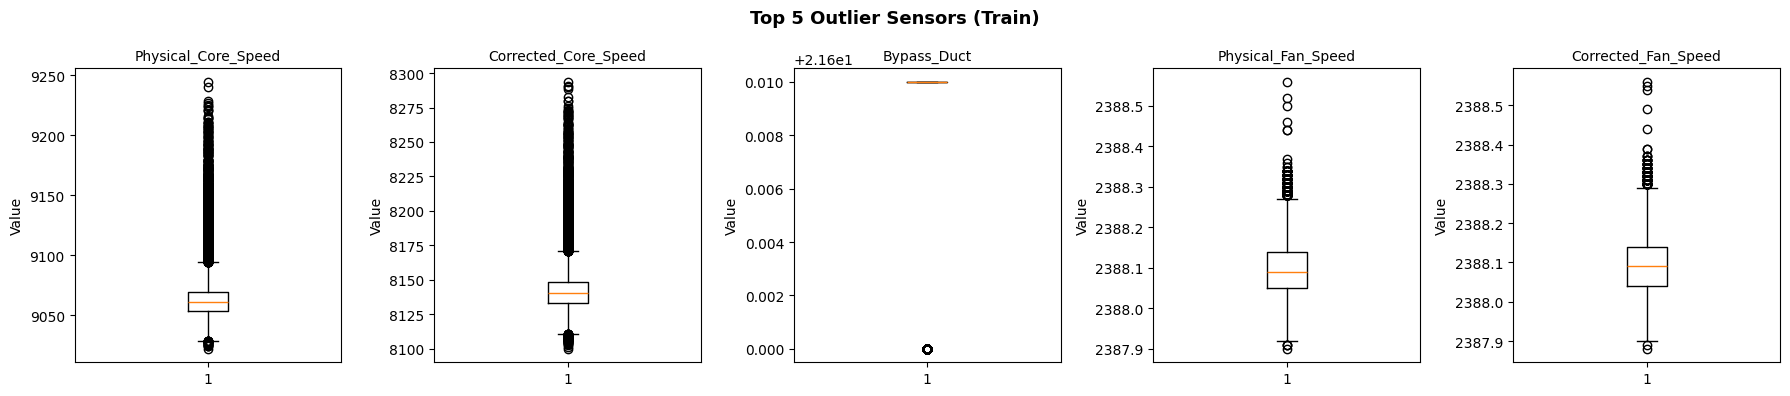

In [14]:
# 12/ Outlier detection (z-score based, Train only)
print_header("Outlier Analysis (Train)")

df_numeric = train1.drop(['unit', 'cycle'], axis=1)
z_scores = np.abs(zscore(df_numeric, nan_policy='omit'))
outlier_mask = z_scores > 3
outlier_counts = outlier_mask.sum(axis=0)

# Summary
outlier_counts = pd.Series(outlier_mask.sum(axis=0), index=df_numeric.columns)
top_5 = outlier_counts.nlargest(5)

print_kv([
    ("Total outliers (z>3)", int(outlier_counts.sum())),
    ("Outlier ratio (%)", f"{(outlier_counts.sum() / df_numeric.size * 100):.2f}"),
])

print("\nTop 5 sensors with most outliers:")
for sensor, count in top_5.items():
    print(f"  {sensor:<25} : {int(count)} ({count/len(df_numeric)*100:.1f}%)")

# Boxplot for top 5 outlier sensors
fig, axes = plt.subplots(1, 5, figsize=(18, 4))
for ax, sensor in zip(axes, top_5.index):
    ax.boxplot(df_numeric[sensor].dropna())
    ax.set_title(sensor, fontsize=10)
    ax.set_ylabel('Value')
plt.suptitle('Top 5 Outlier Sensors (Train)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


Sensor Distribution Comparison (Train vs Test)
Total sensors             : 24
Active sensors (var>0.01) : 11


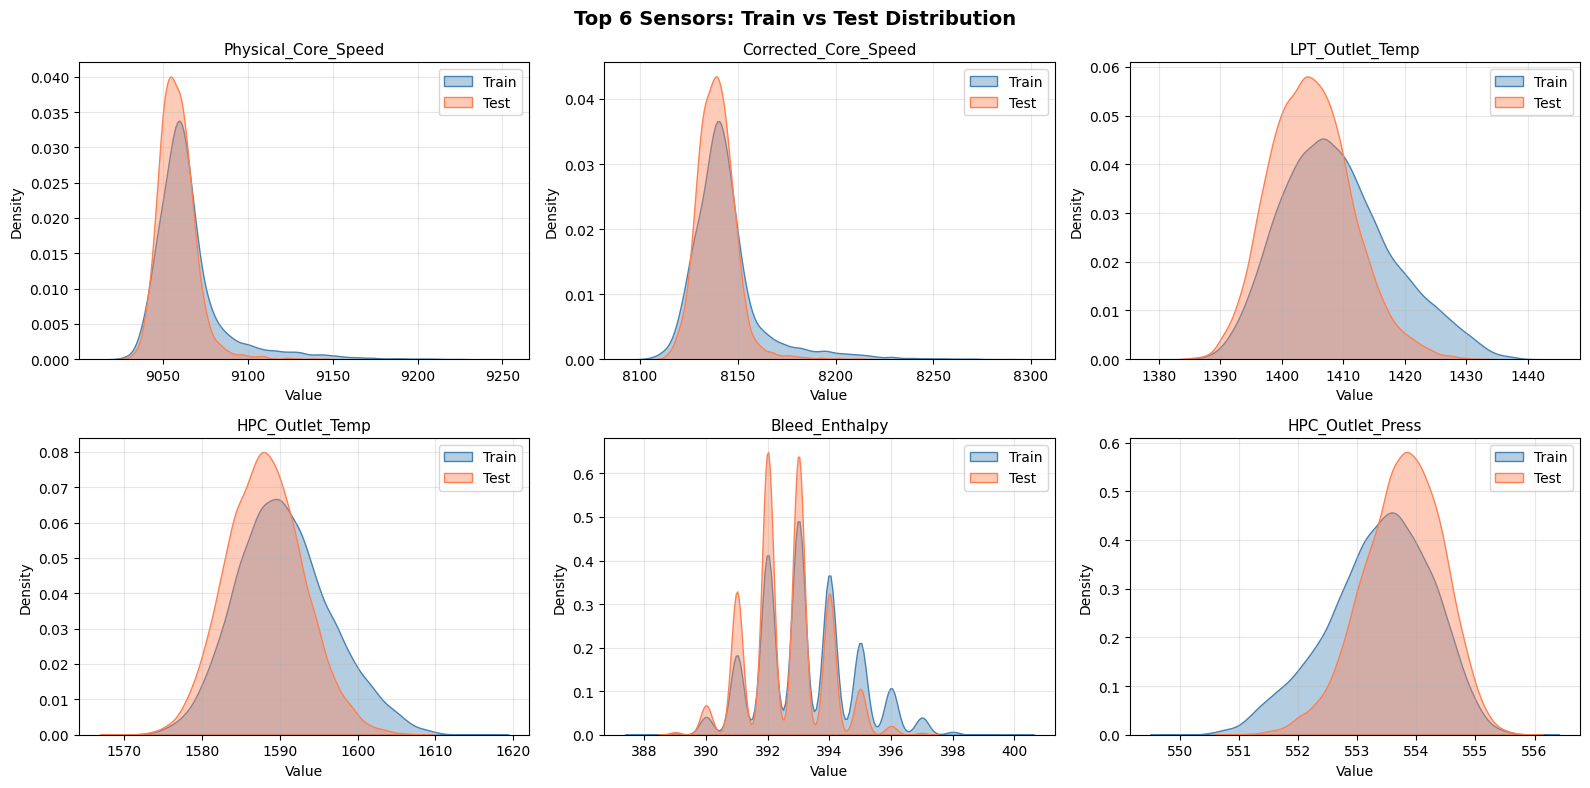


Summary statistics (top 5 active sensors):
  LPC_Outlet_Temp           | Train: mean= 642.68 std=  0.50  | Test: mean= 642.48 std=  0.40
  HPC_Outlet_Temp           | Train: mean=1590.52 std=  6.13  | Test: mean=1588.10 std=  5.00
  LPT_Outlet_Temp           | Train: mean=1408.93 std=  9.00  | Test: mean=1404.74 std=  6.69
  HPC_Outlet_Press          | Train: mean= 553.37 std=  0.89  | Test: mean= 553.76 std=  0.68
  Physical_Core_Speed       | Train: mean=9065.24 std= 22.08  | Test: mean=9058.41 std= 11.44


In [15]:
# 13/ Sensor distribution comparison (Train vs Test — top sensors only)
print_header("Sensor Distribution Comparison (Train vs Test)")

df_numeric_train = train1.drop(['unit', 'cycle'], axis=1)
df_numeric_test = test1.drop(['unit', 'cycle'], axis=1)

# Identify sensors with meaningful variance (exclude near-constant)
variances = df_numeric_train.var()
active_sensors = variances[variances > 0.01].index.tolist()
print_kv([
    ("Total sensors", len(df_numeric_train.columns)),
    ("Active sensors (var>0.01)", len(active_sensors)),
])

# Plot KDE for top 6 active sensors (by variance)
top_sensors = variances.nlargest(6).index
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, sensor in enumerate(top_sensors):
    ax = axes[i]
    sns.kdeplot(df_numeric_train[sensor], ax=ax, label='Train', color='steelblue', fill=True, alpha=0.4)
    sns.kdeplot(df_numeric_test[sensor], ax=ax, label='Test', color='coral', fill=True, alpha=0.4)
    ax.set_title(sensor, fontsize=11)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Top 6 Sensors: Train vs Test Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary stats for top active sensors (abbreviated)
print_header("Summary statistics (top 5 active sensors):")
for sensor in active_sensors[:5]:
    train_mean = df_numeric_train[sensor].mean()
    test_mean = df_numeric_test[sensor].mean()
    train_std = df_numeric_train[sensor].std()
    test_std = df_numeric_test[sensor].std()
    print(f"  {sensor:<25} | Train: mean={train_mean:>7.2f} std={train_std:>6.2f}  | Test: mean={test_mean:>7.2f} std={test_std:>6.2f}")

## 3) Feature Engineering & Preprocessing

In [16]:
# 14/ Constant & Low Variance Feature Removal
print_header("Constant & Low Variance Feature Removal")

# Identify features to drop (exclude unit, cycle, RUL)
features_to_check = train_rul.drop(['unit', 'cycle', 'RUL'], axis=1).columns

# Calculate variance for each feature
variance_threshold = 0.01
low_variance_features = []

for col in features_to_check:
    var = train_rul[col].var()
    if var < variance_threshold:
        low_variance_features.append(col)

# Show features to remove
print(f"Features with variance < {variance_threshold}:")
if len(low_variance_features) > 0:
    for feature in low_variance_features:
        var_value = train_rul[feature].var()
        print(f"  {feature:<25} : variance = {var_value:.6f}")
else:
    print("  None found")

# Remove low variance features from train and test
train_clean = train_rul.drop(low_variance_features, axis=1)
test_clean = test_rul.drop(low_variance_features, axis=1)

# Validation
assert train_clean.shape[0] == train_rul.shape[0], "Row count changed in train"
assert test_clean.shape[0] == test_rul.shape[0], "Row count changed in test"
assert 'RUL' in train_clean.columns and 'RUL' in test_clean.columns, "RUL column missing"

# Summary
remaining_features = train_clean.shape[1] - 3  # exclude unit, cycle, RUL
print_kv([
    ("Original features", len(features_to_check)),
    ("Removed features", len(low_variance_features)),
    ("Remaining features", remaining_features),
    ("Train shape after", train_clean.shape),
    ("Test shape after", test_clean.shape),
])

print("Feature removal complete")


Constant & Low Variance Feature Removal
Features with variance < 0.01:
  opset1                    : variance = 0.000005
  opset2                    : variance = 0.000000
  opset3                    : variance = 0.000000
  Fan_Inlet_Temp            : variance = 0.000000
  Fan_Inlet_Press           : variance = 0.000000
  Bypass_Duct               : variance = 0.000002
  Physical_Fan_Speed        : variance = 0.005039
  Engine_Press_Ratio        : variance = 0.000000
  Corrected_Fan_Speed       : variance = 0.005172
  Bypass_Ratio              : variance = 0.001407
  Fuel_Air_Ratio            : variance = 0.000000
  Req_Fan_Speed             : variance = 0.000000
  Req_Core_Speed            : variance = 0.000000
Original features  : 24
Removed features   : 13
Remaining features : 11
Train shape after  : (20631, 14)
Test shape after   : (13096, 14)
Feature removal complete



Variance Comparison (Before/After Removal)


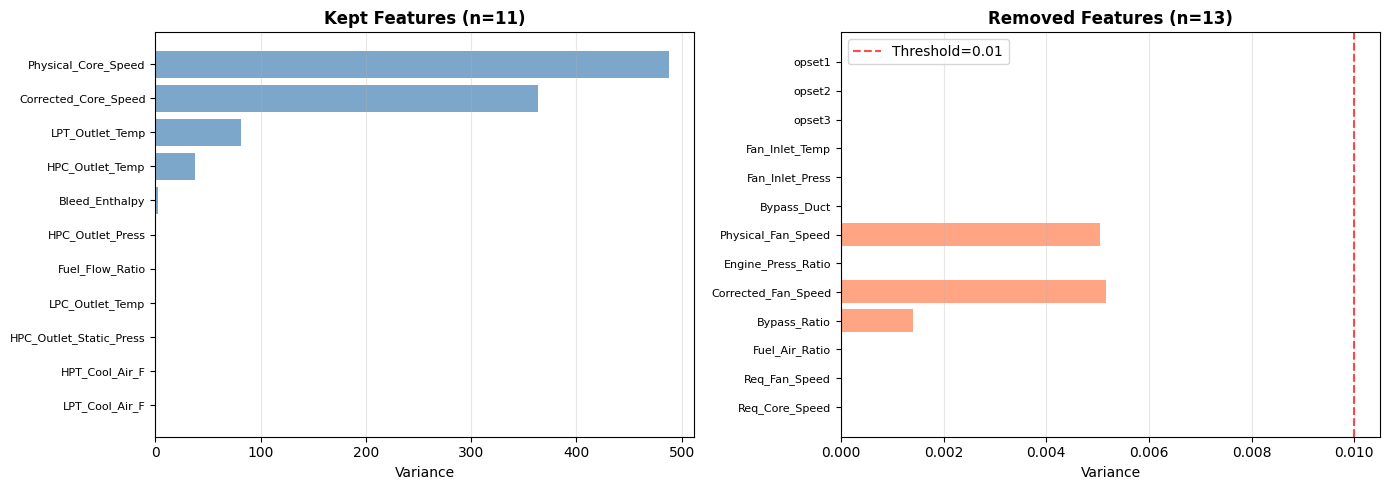

In [17]:
# 14b/ Variance comparison visualization
print_header("Variance Comparison (Before/After Removal)")

# Get variance for all features before removal
all_variances = train_rul.drop(['unit', 'cycle', 'RUL'], axis=1).var().sort_values(ascending=False)

# Separate kept vs removed
kept_features = [f for f in all_variances.index if f not in low_variance_features]
removed_features = low_variance_features

kept_variances = all_variances[kept_features]
removed_variances = all_variances[removed_features] if len(removed_features) > 0 else pd.Series()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Kept features
axes[0].barh(range(len(kept_variances)), kept_variances.values, color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(kept_variances)))
axes[0].set_yticklabels(kept_variances.index, fontsize=8)
axes[0].set_xlabel('Variance')
axes[0].set_title(f'Kept Features (n={len(kept_variances)})', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Removed features
if len(removed_variances) > 0:
    axes[1].barh(range(len(removed_variances)), removed_variances.values, color='coral', alpha=0.7)
    axes[1].set_yticks(range(len(removed_variances)))
    axes[1].set_yticklabels(removed_variances.index, fontsize=8)
    axes[1].set_xlabel('Variance')
    axes[1].set_title(f'Removed Features (n={len(removed_variances)})', fontsize=12, fontweight='bold')
    axes[1].grid(alpha=0.3, axis='x')
    axes[1].axvline(x=0.01, color='red', linestyle='--', alpha=0.7, label='Threshold=0.01')
    axes[1].legend()
    axes[1].invert_yaxis()
else:
    axes[1].text(0.5, 0.5, 'No features removed', ha='center', va='center', fontsize=14)
    axes[1].set_title('Removed Features (n=0)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [18]:
# 15/ Train/Val Split (unit-based, 80/20)
print_header("Train/Val Split (unit-based)")

from sklearn.model_selection import train_test_split

# Get unique units from train set
all_units = train_clean['unit'].unique()
total_units = len(all_units)

# Split units into train and validation (80/20)
train_units, val_units = train_test_split(
    all_units, 
    test_size=0.2, 
    random_state=42
)

# Create train and validation sets based on unit split
train_set = train_clean[train_clean['unit'].isin(train_units)].copy()
val_set = train_clean[train_clean['unit'].isin(val_units)].copy()

# Validation
assert len(train_set) + len(val_set) == len(train_clean), "Row count mismatch after split"
assert train_set['unit'].nunique() == len(train_units), "Train unit count mismatch"
assert val_set['unit'].nunique() == len(val_units), "Val unit count mismatch"

# Check no unit overlap
train_unit_set = set(train_set['unit'].unique())
val_unit_set = set(val_set['unit'].unique())
overlap = train_unit_set.intersection(val_unit_set)
assert len(overlap) == 0, f"Unit overlap detected: {overlap}"

# Summary
print_kv([
    ("Total units", total_units),
    ("Train units", len(train_units)),
    ("Val units", len(val_units)),
    ("Train rows", len(train_set)),
    ("Val rows", len(val_set)),
    ("Split ratio", f"{len(train_set)/len(train_clean)*100:.1f}% / {len(val_set)/len(train_clean)*100:.1f}%"),
])

# RUL distribution check
train_rul_mean = train_set['RUL'].mean()
val_rul_mean = val_set['RUL'].mean()
print_kv([
    ("Train RUL mean", f"{train_rul_mean:.1f}"),
    ("Val RUL mean", f"{val_rul_mean:.1f}"),
])

print_header("Train/Val split complete")


Train/Val Split (unit-based)
Total units : 100
Train units : 80
Val units   : 20
Train rows  : 16561
Val rows    : 4070
Split ratio : 80.3% / 19.7%
Train RUL mean : 108.4
Val RUL mean   : 105.5

Train/Val split complete


In [ ]:
# 16b/ Scaling effect visualization
print_header("Scaling Effect Comparison")


# Select top 3 features (by variance before scaling)
cols_to_scale = [col for col in train_set.columns if col not in ['unit', 'cycle', 'RUL']]
top_features = cols_to_scale[:3]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, feature in enumerate(top_features):
    ax = axes[i]
    
    # Plot train distribution
    ax.hist(train_set[feature], bins=30, color='steelblue', alpha=0.6, label='Train (scaled)', density=True)
    ax.set_title(feature, fontsize=11, fontweight='bold')
    ax.set_xlabel('Scaled Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Feature Distributions After RobustScaler', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("RobustScaler centers data around median=0 and scales by IQR.")

In [19]:
# 16/ Scaling (RobustScaler - fit on train only)
print_header("Feature Scaling")

# Identify columns to scale (exclude unit, cycle, RUL)
cols_to_scale = [col for col in train_set.columns if col not in ['unit', 'cycle', 'RUL']]

# Initialize scaler
scaler = RobustScaler()

# Fit scaler on train set only
scaler.fit(train_set[cols_to_scale])

# Transform train, val, and test sets
train_set[cols_to_scale] = scaler.transform(train_set[cols_to_scale])
val_set[cols_to_scale] = scaler.transform(val_set[cols_to_scale])
test_clean[cols_to_scale] = scaler.transform(test_clean[cols_to_scale])

# Validation
assert train_set[cols_to_scale].isnull().sum().sum() == 0, "Train contains nulls after scaling"
assert val_set[cols_to_scale].isnull().sum().sum() == 0, "Val contains nulls after scaling"
assert test_clean[cols_to_scale].isnull().sum().sum() == 0, "Test contains nulls after scaling"

# Check scaling effect
train_scaled_mean = train_set[cols_to_scale].mean().mean()
train_scaled_std = train_set[cols_to_scale].std().mean()

print_kv([
            ("Scaler type", "RobustScaler"),
            ("Columns scaled", len(cols_to_scale)),
            ("Train scaled mean (avg)", f"{train_scaled_mean:.4f}"),
            ("Train scaled std (avg)", f"{train_scaled_std:.4f}"),
        ])

# Show before/after stats for first 3 features
print("\nScaling effect (first 3 features):")
for col in cols_to_scale[:3]:
    train_min = train_set[col].min()
    train_max = train_set[col].max()
    train_median = train_set[col].median()
    print(f"  {col:<25} | min={train_min:>7.2f} | max={train_max:>7.2f} | median={train_median:>7.2f}")

print("Scaling complete")


Feature Scaling
Scaler type             : RobustScaler
Columns scaled          : 11
Train scaled mean (avg) : 0.0563
Train scaled std (avg)  : 0.8605

Scaling effect (first 3 features):
  LPC_Outlet_Temp           | min=  -2.17 | max=   2.86 | median=   0.00
  HPC_Outlet_Temp           | min=  -2.37 | max=   3.35 | median=   0.00
  LPT_Outlet_Temp           | min=  -1.89 | max=   2.79 | median=   0.00
Scaling complete



Scaling Effect Comparison


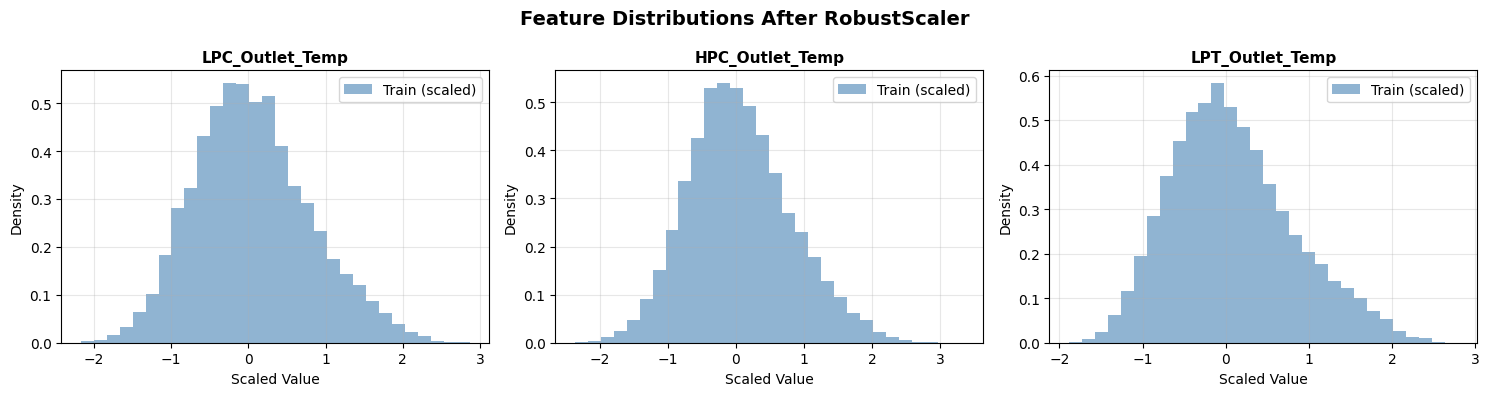

RobustScaler centers data around median=0 and scales by IQR.


In [20]:
# 16b/ Scaling effect visualization
print_header("Scaling Effect Comparison")


# Select top 3 features (by variance before scaling)
top_features = cols_to_scale[:3]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, feature in enumerate(top_features):
    ax = axes[i]
    
    # Plot train distribution
    ax.hist(train_set[feature], bins=30, color='steelblue', alpha=0.6, label='Train (scaled)', density=True)
    ax.set_title(feature, fontsize=11, fontweight='bold')
    ax.set_xlabel('Scaled Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Feature Distributions After RobustScaler', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("RobustScaler centers data around median=0 and scales by IQR.")

In [21]:
# 17/ Rolling Window Features (window=30 cycles)
print_header("Rolling Window Feature Engineering")

def add_rolling_features(df, window_size=30):
    """
    Add rolling window statistics for each sensor per unit.
    Features: mean, std, min, max, slope (linear trend)
    """
    df = df.copy()
    
    # Get sensor columns (exclude unit, cycle, RUL)
    sensor_cols = [col for col in df.columns if col not in ['unit', 'cycle', 'RUL']]
    
    # Initialize empty lists to store new feature columns
    new_features = []
    
    # Process each unit separately
    units = df['unit'].unique()
    
    for unit_id in units:
        # Get data for current unit
        unit_mask = df['unit'] == unit_id
        unit_data = df[unit_mask].copy()
        
        # Sort by cycle to ensure correct order
        unit_data = unit_data.sort_values('cycle')
        
        # Calculate rolling features for each sensor
        for sensor in sensor_cols:
            # Rolling mean
            unit_data[f'{sensor}_roll_mean'] = unit_data[sensor].rolling(window=window_size, min_periods=1).mean()
            
            # Rolling standard deviation
            unit_data[f'{sensor}_roll_std'] = unit_data[sensor].rolling(window=window_size, min_periods=1).std()
            
            # Rolling min
            unit_data[f'{sensor}_roll_min'] = unit_data[sensor].rolling(window=window_size, min_periods=1).min()
            
            # Rolling max
            unit_data[f'{sensor}_roll_max'] = unit_data[sensor].rolling(window=window_size, min_periods=1).max()
            
            # Rolling slope (linear trend)
            def calculate_slope(values):
                if len(values) < 2:
                    return 0
                x = np.arange(len(values))
                y = values.values
                # Simple linear regression: slope = covariance(x,y) / variance(x)
                slope = np.cov(x, y)[0, 1] / np.var(x) if np.var(x) > 0 else 0
                return slope
            
            unit_data[f'{sensor}_roll_slope'] = unit_data[sensor].rolling(window=window_size, min_periods=2).apply(calculate_slope, raw=False)
        
        # Store processed unit data
        new_features.append(unit_data)
    
    # Combine all units
    result = pd.concat(new_features, ignore_index=True)
    
    # Fill any remaining NaN values with 0 (for initial cycles with insufficient history)
    result = result.fillna(0)
    
    return result

# Apply rolling features to train, val, and test
print("Applying rolling window features (window=30)...")
train_set = add_rolling_features(train_set, window_size=30)
val_set = add_rolling_features(val_set, window_size=30)
test_clean = add_rolling_features(test_clean, window_size=30)

# Validation
assert train_set.isnull().sum().sum() == 0, "Train contains nulls after rolling features"
assert val_set.isnull().sum().sum() == 0, "Val contains nulls after rolling features"
assert test_clean.isnull().sum().sum() == 0, "Test contains nulls after rolling features"

# Get feature counts
original_features = len([col for col in cols_to_scale])
rolling_features = len([col for col in train_set.columns if 'roll_' in col])
total_features = train_set.shape[1] - 3  # exclude unit, cycle, RUL

print_kv([
            ("Window size", 30),
            ("Original sensor features", original_features),
            ("New rolling features", rolling_features),
            ("Total features (excl unit/cycle/RUL)", total_features),
            ("Train shape after", train_set.shape),
            ("Val shape after", val_set.shape),
            ("Test shape after", test_clean.shape),
        ])

# Show example of new features (first sensor)
first_sensor = cols_to_scale[0]
rolling_cols = [col for col in train_set.columns if first_sensor in col and 'roll_' in col]
print(f"\nExample rolling features for '{first_sensor}':")
for col in rolling_cols[:5]:  # show first 5
    print(f"  {col}")

print_header("Rolling window features complete")


Rolling Window Feature Engineering
Applying rolling window features (window=30)...
Window size                          : 30
Original sensor features             : 11
New rolling features                 : 55
Total features (excl unit/cycle/RUL) : 66
Train shape after                    : (16561, 69)
Val shape after                      : (4070, 69)
Test shape after                     : (13096, 69)

Example rolling features for 'LPC_Outlet_Temp':
  LPC_Outlet_Temp_roll_mean
  LPC_Outlet_Temp_roll_std
  LPC_Outlet_Temp_roll_min
  LPC_Outlet_Temp_roll_max
  LPC_Outlet_Temp_roll_slope

Rolling window features complete



Rolling Feature Example (Single Unit)


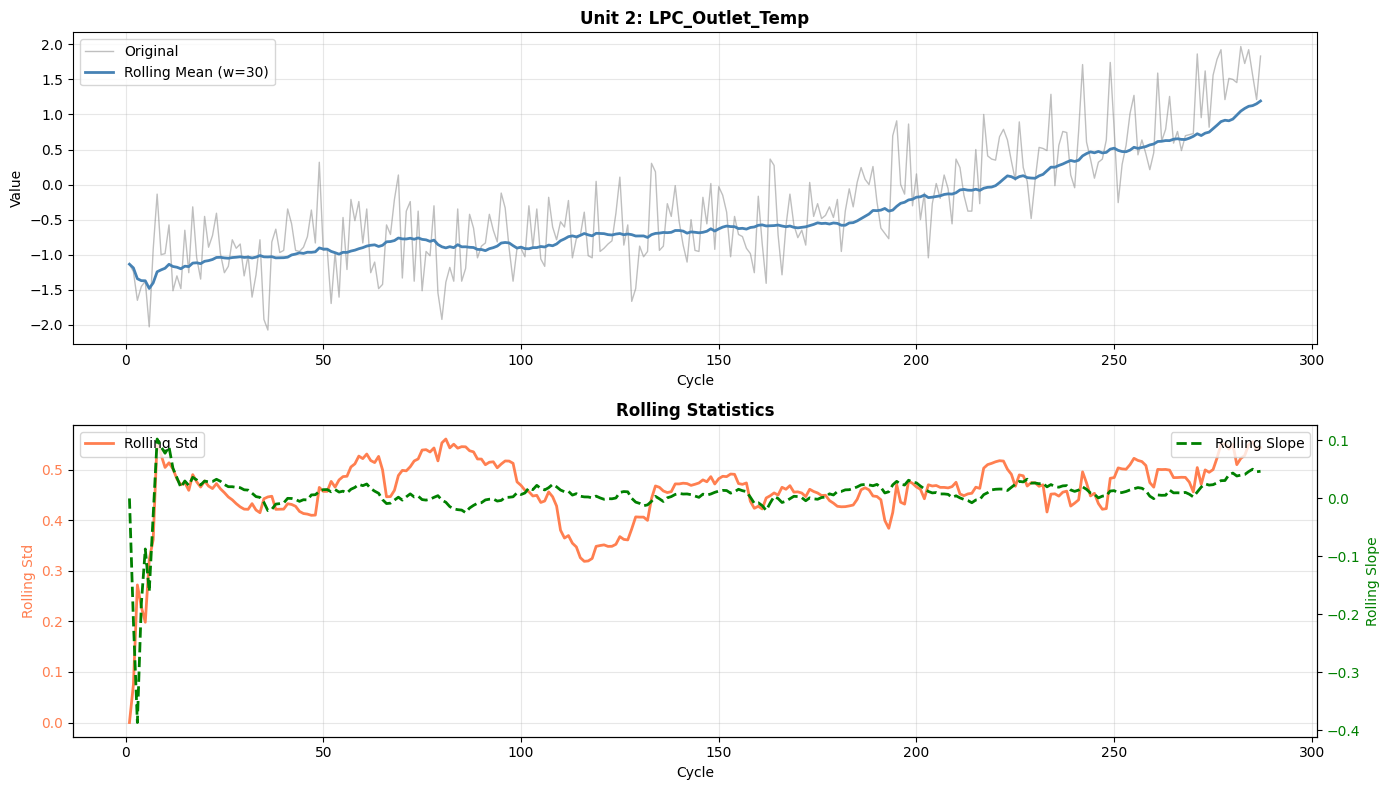

Rolling features capture temporal patterns for unit 2.


In [22]:
# 17b/ Rolling feature visualization (single unit example)
print_header("Rolling Feature Example (Single Unit)")

# Select one unit
example_unit = train_set['unit'].iloc[0]
unit_data = train_set[train_set['unit'] == example_unit].sort_values('cycle')

# Select first sensor
example_sensor = cols_to_scale[0]

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Original + rolling mean
axes[0].plot(unit_data['cycle'], unit_data[example_sensor], 
             label='Original', color='gray', alpha=0.5, linewidth=1)
axes[0].plot(unit_data['cycle'], unit_data[f'{example_sensor}_roll_mean'], 
             label='Rolling Mean (w=30)', color='steelblue', linewidth=2)
axes[0].set_title(f'Unit {example_unit}: {example_sensor}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Rolling std + slope
ax2 = axes[1]
ax2.plot(unit_data['cycle'], unit_data[f'{example_sensor}_roll_std'], 
         label='Rolling Std', color='coral', linewidth=2)
ax2.set_xlabel('Cycle')
ax2.set_ylabel('Rolling Std', color='coral')
ax2.tick_params(axis='y', labelcolor='coral')
ax2.legend(loc='upper left')
ax2.grid(alpha=0.3)

# Add slope on secondary axis
ax3 = ax2.twinx()
ax3.plot(unit_data['cycle'], unit_data[f'{example_sensor}_roll_slope'], 
         label='Rolling Slope', color='green', linewidth=2, linestyle='--')
ax3.set_ylabel('Rolling Slope', color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax3.legend(loc='upper right')

axes[1].set_title('Rolling Statistics', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Rolling features capture temporal patterns for unit {example_unit}.")

In [23]:
# 18/ Sample Weighting (give more weight to low RUL samples)
print_header("Sample Weighting")

def calculate_sample_weights(df, rul_threshold=30, low_rul_weight=2.0):
    """
    Calculate sample weights based on RUL values.
    Samples with RUL < threshold get higher weight.
    """
    df = df.copy()
    
    # Initialize weights array (default weight = 1.0)
    weights = np.ones(len(df))
    
    # Find samples with low RUL
    low_rul_mask = df['RUL'] < rul_threshold
    
    # Assign higher weight to low RUL samples
    weights[low_rul_mask] = low_rul_weight
    
    return weights

# Calculate weights for train and val sets
train_weights = calculate_sample_weights(train_set, rul_threshold=30, low_rul_weight=2.0)
val_weights = calculate_sample_weights(val_set, rul_threshold=30, low_rul_weight=2.0)

# Validation
assert len(train_weights) == len(train_set), "Train weights length mismatch"
assert len(val_weights) == len(val_set), "Val weights length mismatch"
assert (train_weights >= 1.0).all(), "Train weights contain values less than 1.0"
assert (val_weights >= 1.0).all(), "Val weights contain values less than 1.0"

# Count weighted samples
train_low_rul_count = (train_set['RUL'] < 30).sum()
train_high_weight_count = (train_weights > 1.0).sum()
val_low_rul_count = (val_set['RUL'] < 30).sum()
val_high_weight_count = (val_weights > 1.0).sum()

# Summary
print_kv([
            ("RUL threshold", 30),
            ("Low RUL weight", 2.0),
            ("High RUL weight", 1.0),
        ])

print("\nTrain set:")
print_kv([
            ("Total samples", len(train_set)),
            ("Low RUL samples (RUL<30)", train_low_rul_count),
            ("High weight samples", train_high_weight_count),
            ("Low RUL ratio (%)", f"{train_low_rul_count/len(train_set)*100:.1f}"),
        ])

print("\nVal set:")
print_kv([
            ("Total samples", len(val_set)),
            ("Low RUL samples (RUL<30)", val_low_rul_count),
            ("High weight samples", val_high_weight_count),
            ("Low RUL ratio (%)", f"{val_low_rul_count/len(val_set)*100:.1f}"),
        ])

# Weight distribution
print("\nWeight distribution (train):")
unique_weights = np.unique(train_weights)
for weight in unique_weights:
    count = (train_weights == weight).sum()
    percentage = count / len(train_weights) * 100
    print(f"  weight={weight:.1f} : {count:>6} samples ({percentage:>5.1f}%)")

print_header("Sample weighting complete")


Sample Weighting
RUL threshold   : 30
Low RUL weight  : 2.0
High RUL weight : 1.0

Train set:
Total samples            : 16561
Low RUL samples (RUL<30) : 2400
High weight samples      : 2400
Low RUL ratio (%)        : 14.5

Val set:
Total samples            : 4070
Low RUL samples (RUL<30) : 600
High weight samples      : 600
Low RUL ratio (%)        : 14.7

Weight distribution (train):
  weight=1.0 :  14161 samples ( 85.5%)
  weight=2.0 :   2400 samples ( 14.5%)

Sample weighting complete



Sample Weight Distribution Visualization


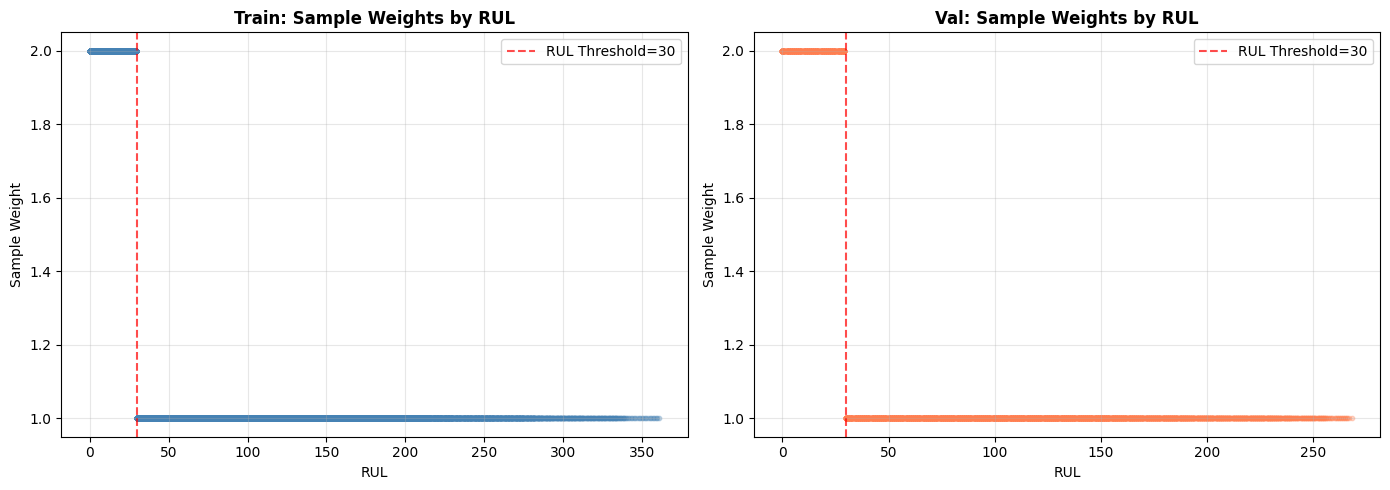

Samples with RUL<30 receive 2x weight to improve critical failure prediction.


In [24]:
# 18b/ Sample weight distribution visualization
print_header("Sample Weight Distribution Visualization")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train: RUL vs Weight
axes[0].scatter(train_set['RUL'], train_weights, alpha=0.3, color='steelblue', s=10)
axes[0].axvline(x=30, color='red', linestyle='--', alpha=0.7, label='RUL Threshold=30')
axes[0].set_xlabel('RUL')
axes[0].set_ylabel('Sample Weight')
axes[0].set_title('Train: Sample Weights by RUL', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Val: RUL vs Weight
axes[1].scatter(val_set['RUL'], val_weights, alpha=0.3, color='coral', s=10)
axes[1].axvline(x=30, color='red', linestyle='--', alpha=0.7, label='RUL Threshold=30')
axes[1].set_xlabel('RUL')
axes[1].set_ylabel('Sample Weight')
axes[1].set_title('Val: Sample Weights by RUL', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Samples with RUL<30 receive 2x weight to improve critical failure prediction.")

## 4) Model Training & Evaluation